# Predicting the Popularity of Venues in Downtown Toronto

__TODO__: Add description of the project (it can be the same description as the one in the assignment)

## Import the necessary libraries

In [57]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import scipy as sp

from scipy.spatial import distance  # distance matrix computations
from scipy.cluster import hierarchy  # hierarchical clustering

from sklearn.preprocessing import MinMaxScaler  # used to normalize data

import networkx as nx  # plot graphs

import pgeocode  # get latitude and longitude from a postal code

import requests  # handle requests
from bs4 import BeautifulSoup  # web scraper

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pylab  # plotting dendograms
import seaborn as sns  # plotting in general

import folium  # map rendering library

import warnings

## Get the data for vehicle and foot traffic from the Toronto Open Data API

In [163]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
payload = {"id": "ae4e10a2-9eaf-4da4-83fb-f3731a30c124"}
response = requests.get(url, params=payload).json()
traffic_df = pd.read_excel(response["result"]['resources'][0]['url'])

col_rename = {'TCS #': 'id', 'Side 1 Route': 'Side1', 'Side 2 Route': 'Side2',
              '8 Peak Hr Vehicle Volume': 'VehicleVolume',
              '8 Peak Hr Pedestrian Volume': 'PedestrianVolume'}
traffic_df.drop(['Midblock Route', 'Activation Date', 'Count Date'], axis=1, inplace=True)
traffic_df.rename(columns=col_rename, inplace=True)
traffic_df.head()

,id,Main,Side1,Side2,Latitude,Longitude,VehicleVolume,PedestrianVolume
0,2,JARVIS ST,FRONT ST E,NaN,43.649418,-79.371446,15662,13535
1,3,KING ST E,JARVIS ST,NaN,43.650461,-79.371924,12960,7333
2,4,JARVIS ST,ADELAIDE ST E,NaN,43.651534,-79.372360,17770,7083
3,5,JARVIS ST,RICHMOND ST E,NaN,43.652718,-79.372824,19678,4369
4,6,JARVIS ST,QUEEN ST E,NaN,43.653704,-79.373238,14487,3368


In [164]:
count_main = traffic_df['Main'].value_counts().reset_index()
count_main.columns = ['Main', 'Count']

traffic_df = traffic_df.merge(count_main.set_index('Main'), on='Main')
traffic_df.sort_values(by='Count', ascending=False, inplace=True)
traffic_df.head()

,id,Main,Side1,Side2,Latitude,Longitude,VehicleVolume,PedestrianVolume,Count
111,34,YONGE ST,QUEEN ST,NaN,43.652421,-79.379276,10956,21936,69
131,55,YONGE ST,LAWRENCE AVE,NaN,43.725103,-79.402193,24489,9198,69
125,49,YONGE ST,EGLINTON AVE,NaN,43.706750,-79.398311,23360,20902,69
126,50,YONGE ST,BROADWAY AVE,MONTGOMERY AVE,43.709554,-79.398943,16937,14176,69
127,51,YONGE ST,CASTLEFIELD AVE,NaN,43.711855,-79.399437,15456,3080,69


In [165]:
lat = 43.6525
lng = -79.381667
m = 5000  # metres
a = 6378137  # Radius of earth at equator (m)
e2 = 0.00669437999014  # eccentricity squared
r = np.pi / 180  # convert to radians

# distance of 1 degree latitude
d1 = r * a * (1 - e2) / (1 - e2 * np.sin(lat * r) ** 2) ** (3 / 2)

# distance of 1 degree longitude
d2 = r * a * np.cos(lat * r) / np.sqrt(1 - e2 * np.sin(lat * r) ** 2)

# Bounding box coordinates
min_lat, max_lat = lat - m / d1, lat + m / d1
min_lng, max_lng = lng - m / d2, lng + m / d2

print(min_lat, min_lng, max_lat, max_lng)

43.60749771086355 -79.4436457319317 43.69750228913646 -79.31968826806829


In [166]:
print(traffic_df.shape)
lat_bool = traffic_df.Latitude.between(min_lat, max_lat)
lng_bool = traffic_df.Longitude.between(min_lng, max_lng)

traffic_df = traffic_df[lat_bool & lng_bool]
print(traffic_df.shape)

(2280, 9)
(543, 9)


In [172]:
def CreateMap(lat, lng, zoom_start=12, with_colour=False, n_clusters=0):
    # if with_colour = True, you must specify the number of clusters
    
    # create map
    m = folium.Map(location=[43.65, -79.38], zoom_start=zoom_start)

    if with_colour:
        # set color scheme for the clusters
        x = np.arange(n_clusters)
        ys = [i + x + (i*x)**2 for i in range(n_clusters)]
        colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    if with_colour:
        for lat, lng, main_st, side_st, cluster in zip(traffic_df['Latitude'],
                                                       traffic_df['Longitude'],
                                                       traffic_df['Main'], 
                                                       traffic_df['Side1'],
                                                       traffic_df['ClusterLabel']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_opacity=0.7).add_to(m)
    else:
        for lat, lng, main_st, side_st in zip(traffic_df['Latitude'],
                                              traffic_df['Longitude'],
                                              traffic_df['Main'], 
                                              traffic_df['Side1']):

            label = folium.Popup(str(main_st) + ' & ' + str(side_st), parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=3,
                popup=label,
                fill=True,
                fill_opacity=0.7).add_to(m)

    return m

In [173]:
CreateMap(43.65, -79.38)

In [174]:
features = ['Latitude', 'Longitude']
feature_set = traffic_df[features]

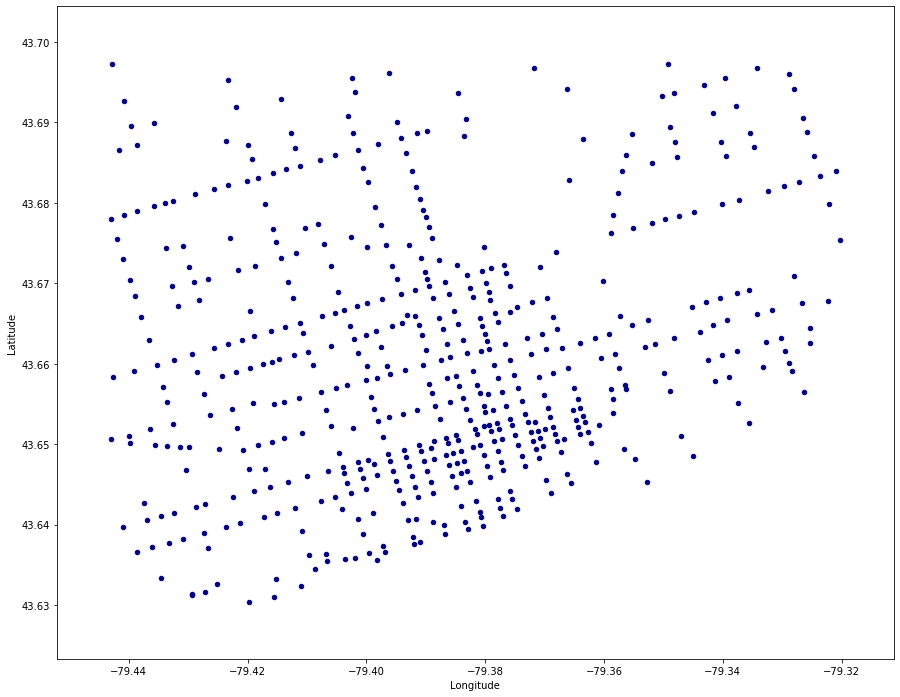

In [175]:
traffic_df.plot.scatter(x='Longitude', y='Latitude', c='DarkBlue',figsize=(15,12))

In order to determine if the features need to be normalized, let's look at the range of each feature.

In [176]:
traffic_df[features].max() - traffic_df[features].min()

Latitude     0.066837
Longitude    0.122761
dtype: float64

We see that the ranges differ significantly, so we will normalize our data to get a more accurate clustering.

In [177]:
x = feature_set.values
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

array([[0.32863286, 0.51957869],
       [0.8620798 , 0.39884002],
       [0.3870599 , 0.50625199],
       [0.24522272, 0.53868085],
       [0.26022036, 0.53525957]])

Now we calculate the distance matrix of the feature matrix. We use the _cityblock_ metric to calculate the city block distance between the points.

In [178]:
# calculate the distance between points
dist_array = distance.pdist(feature_mtx, metric='cityblock')

# calculate the distance matrix to be used in hierarchical clustering
dist_matrix = distance.squareform(dist_array)
dist_matrix

array([[0.        , 0.65418561, 0.07175375, ..., 0.46407128, 0.57981588,
        0.03278002],
       [0.65418561, 0.        , 0.58243186, ..., 0.87677955, 0.99252415,
        0.630138  ],
       [0.07175375, 0.58243186, 0.        , ..., 0.50917161, 0.62491622,
        0.04770614],
       ...,
       [0.46407128, 0.87677955, 0.50917161, ..., 0.        , 0.1157446 ,
        0.4968513 ],
       [0.57981588, 0.99252415, 0.62491622, ..., 0.1157446 , 0.        ,
        0.61259591],
       [0.03278002, 0.630138  , 0.04770614, ..., 0.4968513 , 0.61259591,
        0.        ]])

Now we want to use the distance matrix to create a hierarchical clustering of the intersections using their proximity to each other. The goal is to cluster intersections that are close to each other in order to later retrieve the venues that are inside each cluster.

In [179]:
# ignore warning when performing the agglomerative clustering
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    Z = hierarchy.linkage(dist_matrix, method='average')

In [180]:
max_clusters = 10
clusters = hierarchy.fcluster(Z, max_clusters, criterion='maxclust')
#clusters

In [181]:
traffic_df['ClusterLabel'] = clusters

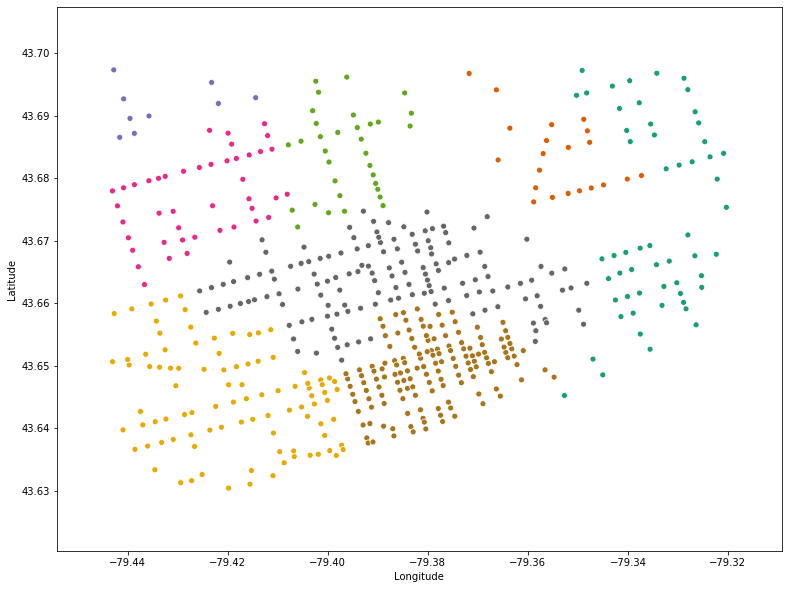

In [182]:
plt.figure(figsize=(13,10))
ax = sns.scatterplot(x='Longitude', y='Latitude', data=traffic_df, hue='ClusterLabel', palette='Dark2', legend=False)

In [183]:
CreateMap(43.65, -79.38, with_colour=True, n_clusters=max_clusters)